## **PRACTICAL SESSION 1** — Deep Learning for predictive maintenance

The dataset used is the **AI4I 2020** Predictive Maintenance Dataset, which contains 10,000 instances of industrial sensor data. Each instance represents the operating condition of a machine and is associated with a label indicating whether a failure has occurred and, if so, what type of failure it is.

The 5 possible labels are:



*   **TWF**: Tool Wear Failure
*   **HDF**: Heat Dissipation Failure
*   **PWF**: Power Failure
*   **OSF**: Overstrain Failure
*   **RNF**: Random Failure


The data is available on eCAMPUS as CSV file called: "ai4i2020.csv"



## **PRACTICAL SESSION Goal** — Ceate a deep leanring model allowing to realize a predictive maintenance mission

## **1 - Analysis of the dataset**



All libraries used ***SHOULD BE PLACED*** in the code cell below

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout

**QUESTION:** Load dataset and display some lines of the csv file.

In [14]:
df = pd.read_csv('../data/ai4i2020.csv')
print(df.head(10))

   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   
5    6     M14865    M                298.1                    308.6   
6    7     L47186    L                298.1                    308.6   
7    8     L47187    L                298.1                    308.6   
8    9     M14868    M                298.3                    308.7   
9   10     M14869    M                298.5                    309.0   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3       

**QUESTION:** Display the distribution of machine failures and non-failures with a bar graph.

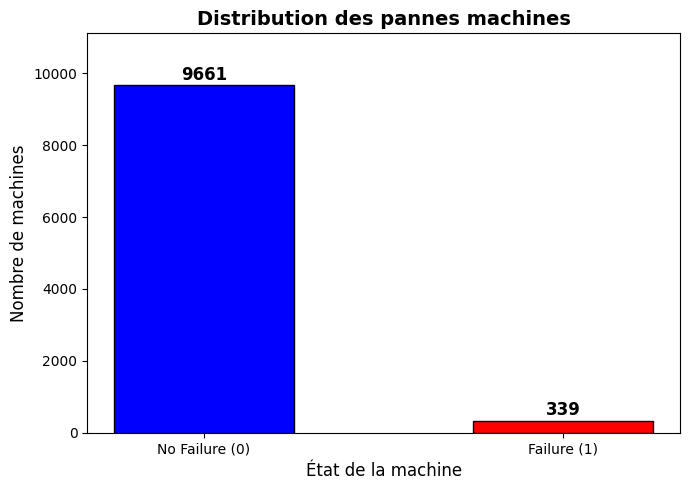

No Failure (0) : 9661 (96.6%)
Failure (1) : 339 (3.4%)


In [15]:
# comptage du nombre de machines en panne (1) et sans panne (0)
counts = df['Machine failure'].value_counts().sort_index()
labels = ['No Failure (0)', 'Failure (1)']

fig, ax = plt.subplots(figsize=(7, 5))
bars = ax.bar(labels, counts.values, color=['blue', 'red'], edgecolor='black', width=0.5)

# affichage de la valeur exacte au-dessus de chaque barre
for bar in bars:
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 50,
        str(int(bar.get_height())),
        ha='center', va='bottom', fontsize=12, fontweight='bold'
    )

ax.set_title('Distribution des pannes machines', fontsize=14, fontweight='bold')
ax.set_xlabel('État de la machine', fontsize=12)
ax.set_ylabel('Nombre de machines', fontsize=12)
ax.set_ylim(0, counts.max() * 1.15)

plt.tight_layout()
plt.savefig('../images/distribution_pannes.png', dpi=150)
plt.show()

# affichage du pourcentage pour chaque classe
total = counts.sum()
for i, (label, count) in enumerate(zip(labels, counts.values)):
    print(f"{label} : {count} ({count / total * 100:.1f}%)")

**ANALYSIS QUESTION:** What do you observe?

On observe un fort déséquilibre entre les deux classes puisque environ 9 661 machines n'ont pas subi de panne (≈ 96,6%) contre seulement 339 machines en panne (≈ 3,4%). Ce déséquilibre n'est pas très surprenant car on espère en effet qu'il y a moins de machines défectueuses qu'en bon état, mais ça pourrait poser des problèmes pour notre modèle.

**ANALYSIS QUESTION:** What will be the consequence of this phenomenon on the model's learning?

Le problème est que, pour la loss function, la stratégie la plus simple pour un modèle est de prédire systématiquement "No Failure" quelle que soit l'entrée. Ce faisant, il atteint mécaniquement une accuracy de 96,6 % sans avoir rien appris d'utile: c'est ce qu'on appelle le biais de classe majoritaire. Ce serait évdiemment trompeur car cela donne l'illustion qu'on a un bon modèle alors qu'il raterait 100 % des pannes réelles.

Dans un contexte industriel pour la maintenance prédictive, c'est l'inverse de ce qu'on cherche. Manquer une panne (faux négatif) peut entraîner des arrêts de production non planifiés, voire des accidents, tandis qu'une fausse alarme (faux positif) a des conséquences bien plus limitées. La classe minoritaire est donc paradoxalement la plus importante, et les métriques classiques comme l'accuracy ne suffisent pas pour évaluer correctement les performances du modèle sur ce type de données.

**QUESTION:** Create a bar chart showing the distribution of different failure types (TWF, HDF, PWF, OSF, RNF). Display the exact values above each bar in the chart."

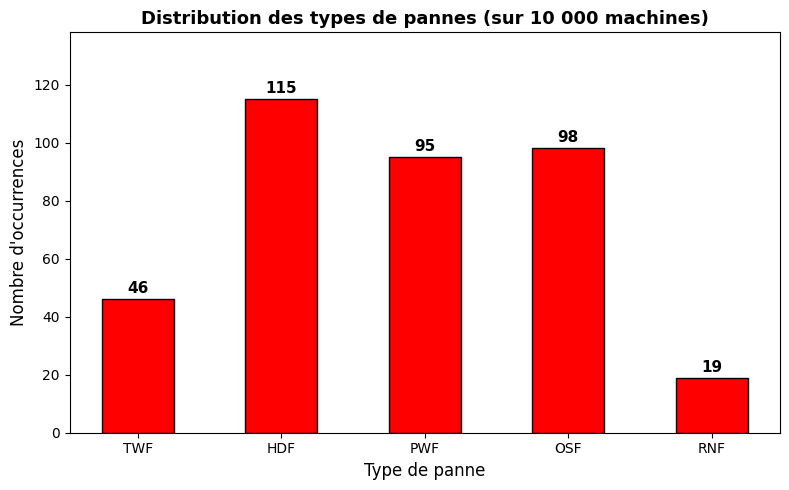

TWF : 46 occurrences
HDF : 115 occurrences
PWF : 95 occurrences
OSF : 98 occurrences
RNF : 19 occurrences


In [16]:
# colonnes correspondant aux types de pannes du dataset
failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']

# comptage du nombre d'occurrences de chaque type de panne (valeur 1 = panne présente)
failure_counts = df[failure_types].sum()

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(failure_types, failure_counts.values, color='red', edgecolor='black', width=0.5)

# affichage de la valeur exacte au-dessus de chaque barre
for bar in bars:
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 1,
        str(int(bar.get_height())),
        ha='center', va='bottom', fontsize=11, fontweight='bold'
    )

ax.set_title('Distribution des types de pannes (sur 10 000 machines)', fontsize=13, fontweight='bold')
ax.set_xlabel('Type de panne', fontsize=12)
ax.set_ylabel('Nombre d\'occurrences', fontsize=12)
ax.set_ylim(0, failure_counts.max() * 1.2)

plt.tight_layout()
plt.savefig('../images/distribution_types_pannes.png', dpi=150)
plt.show()

# affichage des valeurs brutes pour référence
for ftype, count in failure_counts.items():
    print(f"{ftype} : {count} occurrences")


**ANALYSIS QUESTION:** What do you observe?

Premièrement toutes les pannes sont rares. Aucun type ne dépasse quelques dizaines à une centaine d'occurrences sur 10 000 machines, ce qui confirme le fort déséquilibre déjà observé précédemment. 

Autrement, parmi les cinq types, HDF (Heat Dissipation Failure) est le plus représenté, suivi de près par OSF et PWF. TWF est déjà nettement moins fréquent.

Par ailleurs, RNF (Random Failure) se distingue par son nombre d'occurrences très faible (19 seulement). C'est un cas limite : avec si peu d'exemples, un modèle aura extrêmement de mal à apprendre les caractéristiques propres à ce type de panne. Il faudra probablement prendre une décision sur la façon de le traiter.

Enfin, la somme de ces occurrences dépasse légèrement les 339 défaillances totales identifiées dans le graphique précédent. Cela suggère que certaines machines ont subi plusieurs types de pannes simultanément, ce qui est cohérent avec un environnement industriel réel où un dysfonctionnement peut se propager ou avoir plusieurs causes.

**QUESTION:** Create a bar chart showing the distribution of failure types (TWF, HDF, PWF, OSF, RNF) among machines that experienced a failure (Machine failure == 1). Additionally, add a "No Specific Failure" category to count cases where a machine failed but no specific failure type was recorded. Display the exact values above each bar in the chart."

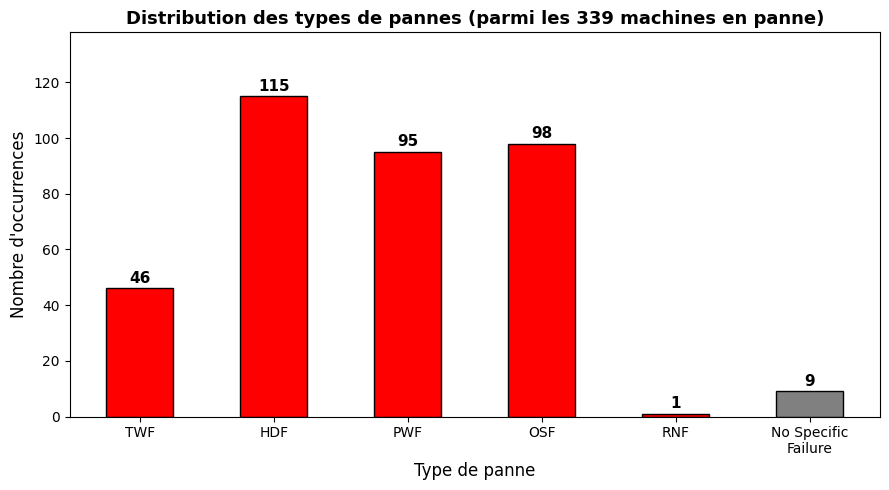

TWF : 46 occurrences
HDF : 115 occurrences
PWF : 95 occurrences
OSF : 98 occurrences
RNF : 1 occurrences
No Specific Failure : 9 occurrences


In [17]:
# filtrage des machines ayant subi une panne
df_failures = df[df['Machine failure'] == 1]

failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']

# comptage des occurrences de chaque type de panne parmi les machines en panne
failure_counts = df_failures[failure_types].sum()

# ajout de la catégorie "No Specific Failure" : machines en panne sans aucun type identifié
no_specific = (df_failures[failure_types].sum(axis=1) == 0).sum()
failure_counts['No Specific\nFailure'] = no_specific

labels = list(failure_counts.index)
colors = ['red'] * len(failure_types) + ['gray']

fig, ax = plt.subplots(figsize=(9, 5))
bars = ax.bar(labels, failure_counts.values, color=colors, edgecolor='black', width=0.5)

# affichage de la valeur exacte au-dessus de chaque barre
for bar in bars:
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 1,
        str(int(bar.get_height())),
        ha='center', va='bottom', fontsize=11, fontweight='bold'
    )

ax.set_title('Distribution des types de pannes (parmi les 339 machines en panne)', fontsize=13, fontweight='bold')
ax.set_xlabel('Type de panne', fontsize=12)
ax.set_ylabel('Nombre d\'occurrences', fontsize=12)
ax.set_ylim(0, failure_counts.max() * 1.2)

plt.tight_layout()
plt.savefig('../images/distribution_types_pannes_filtered.png', dpi=150)
plt.show()

for ftype, count in failure_counts.items():
    print(f"{ftype.replace(chr(10), ' ')} : {int(count)} occurrences")

**ANALYSIS QUESTION:** What do you obsrve comapred to the previous question ? What can you conclude?

Par rapport au graphique précédent qui comptabilisait les occurrences de chaque type de panne sur l'ensemble des 10 000 machines, ce nouveau graphique se restreint aux 339 machines effectivement en pane. Les proportions relatives entre les types restent similaires (HDF et OSF dominent, RNF reste marginal), ce qui montre une cohérence entre les deux représentations.

La principale nouveauté est l'apparition de la catégorie "No Specific Failure" : elle regroupe les machines dont le flag Machine failure vaut 1 mais pour lesquelles aucun des cinq types de panne n'est renseigné. Ce nombre est faible mais non nul, ce qui traduit une légère incohérence dans l'étiquetage du dataset, des pannes génériques sans cause identifiée.

Par ailleurs, si l'on somme toutes les barres (types identifiés + No Specific Failure), on obtient un total légèrement supérieur à 339. Cela confirme que certaines machines ont déclenché plusieurs types de pannes simultanément, un phénomène déjà suspecté dans l'analyse précédente.

On peut donc conclure que la colonne Machine failure n'est pas strictement redondante avec les colonnes de types : elle capte des cas non couverts par ces dernières. Il faudra donc en tenir compte dans le choix des sorties du modèle.


**QUESTION:** Display the names of the different columns in the dataset with their respective data types.

In [18]:
# affichage des noms de colonnes et de leurs types de données
print("Colonnes et types de données du dataset :\n")
for col, dtype in df.dtypes.items():
    print(f"  {col:<30} -> {dtype}")

Colonnes et types de données du dataset :

  UDI                            -> int64
  Product ID                     -> str
  Type                           -> str
  Air temperature [K]            -> float64
  Process temperature [K]        -> float64
  Rotational speed [rpm]         -> int64
  Torque [Nm]                    -> float64
  Tool wear [min]                -> int64
  Machine failure                -> int64
  TWF                            -> int64
  HDF                            -> int64
  PWF                            -> int64
  OSF                            -> int64
  RNF                            -> int64


**ANALYSIS QUESTION:** To train the model, what will be the inputs and outputs (What are the names of the columns that you will use?)? Justify your response.
Remember, you want to predict if the machine will fail, and if so, what kind of failure. You need to yse previous results to jsurtify your response.

**Inputs:**
Les colonnes utilisées comme entrées du modèle seront les mesures physiques des capteurs, à savoir : `Air temperature [K]`, `Process temperature [K]`, `Rotational speed [rpm]`, `Torque [Nm]`, `Tool wear [min]`, mais aussi la colonne `Type` (type de machine : L, M, H) après encodage (one-hot ou label encoding). Les colonnes `UDI` et `Product ID` sont de simples identifiants sans valeur prédictive et doivent être exclues.

**Outputs:**
Le modèle doit répondre à deux sous-problèmes simultanément détecter si une panne a lieu et, si oui, en identifier le type. Les colonnes de sortie seront donc `Machine failure`, `TWF`, `HDF`, `PWF`, `OSF` et `RNF`, soit 6 sorties binaires. Cela correspond à un problème de classification multi-label.

Comme montré dans l'analyse précédente, la colonne `Machine failure` n'est pas strictement redondante avec les cinq types de pannes: certaines machines ont un flag `Machine failure = 1` sans qu'aucun type spécifique ne soit renseigné (catégorie "No Specific Failure"). La supprimer ferait perdre de l'information. Par ailleurs, certaines machines cumulent plusieurs types de pannes simultanément, ce qui confirme que le problème est bien multi-label et non multi-classe : on ne peut pas se contenter d'une seule sotrie avec une classe par type de panne.

## **2- Train model Without balancing the dataset**

---



In this section, you must build and train a model without rebalancing the dataset.

**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [19]:
# encodage de la colonne 'Type' (L, M, H) en valeurs numériques (0, 1, 2)
le = LabelEncoder()
df['Type_encoded'] = le.fit_transform(df['Type'])

# définition des colonnes d'entrée : mesures capteurs + type de machine encodé
# on exclut 'UDI' et 'Product ID' qui sont de simples identifiants sans valeur prédictive
input_cols = [
    'Air temperature [K]',
    'Process temperature [K]',
    'Rotational speed [rpm]',
    'Torque [Nm]',
    'Tool wear [min]',
    'Type_encoded'
]

# définition des colonnes de sortie : panne globale + 5 types de pannes (problème multi-label)
output_cols = ['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']

X = df[input_cols].values
Y = df[output_cols].values

# séparation en jeu d'entraînement (80%) et de test (20%), seed fixée pour la reproductibilité
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f"X_train : {X_train.shape[0]} éléments  ({X_train.shape[1]} features)")
print(f"Y_train : {Y_train.shape[0]} éléments  ({Y_train.shape[1]} labels)")
print(f"X_test  : {X_test.shape[0]} éléments  ({X_test.shape[1]} features)")
print(f"Y_test  : {Y_test.shape[0]} éléments  ({Y_test.shape[1]} labels)")

X_train : 8000 éléments  (6 features)
Y_train : 8000 éléments  (6 labels)
X_test  : 2000 éléments  (6 features)
Y_test  : 2000 éléments  (6 labels)


**QUESTION** Code below the model architecture

In [22]:
n_inputs  = X_train.shape[1]  # 6 features
n_outputs = Y_train.shape[1]  # 6 labels binaires (multi-label)

model = Sequential([
    # couche d'entrée + première couche cachée
    Dense(64, input_dim=n_inputs, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # deuxième couche cachée
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # couche de sortie : une sortie par label, activation sigmoid pour classification binaire indépendante
    Dense(n_outputs, activation='sigmoid')
])

# binary_crossentropy : adaptée au multi-label (chaque sortie est traitée indépendamment)
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

c:\Users\matte\Documents\embedded_AI\Projet_Maintenance_Predictive\.venv\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,110 (12.15 KB)

 Trainable params: 2,918 (11.40 KB)

 Non-trainable params: 192 (768.00 B)

**QUESTION** Code below the algorithms allowing to train model

**WARNING!** You need to plot the training and test accuracy and loss to check if our model is overfitting

In [ ]:
# entraînement du modèle sur 50 epochs avec un batch size de 32
# on utilise 10% des données d'entraînement comme validation set pour surveiller l'overfitting
history = model.fit(
    X_train, Y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# --- visualisation des courbes d'entraînement ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# courbe de loss
ax1.plot(history.history['loss'],     label='Train Loss',      color='blue')
ax1.plot(history.history['val_loss'], label='Validation Loss', color='red', linestyle='--')
ax1.set_title('Loss (sans rééquilibrage)', fontsize=13, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Binary Crossentropy')
ax1.legend()
ax1.grid(True)

# courbe d'accuracy
ax2.plot(history.history['accuracy'],     label='Train Accuracy',      color='blue')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red', linestyle='--')
ax2.set_title('Accuracy (sans rééquilibrage)', fontsize=13, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('../images/training_curves_no_balance.png', dpi=150)
plt.show()

# affichage des métriques finales sur le les data de test
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=0)
print(f"\nTest Loss     : {test_loss:.4f}")
print(f"Test Accuracy : {test_acc:.4f}")

**QUESTION** Plot the confusion matrix and the classification report

**Tips:**

*   classification report link

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

*   Matrix confusion

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html





**ANALYSIS QUESTION** What do you observe? What can you conclude?

"Write your response here"

## **3- Train model With balancing the dataset**

---

 Methods for rebalancing a dataset:


*   Use oversampling techniques (e.g., SMOTE) to generate synthetic data for minority classes


> https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html



*   Apply undersampling techniques (e.g., random undersampling, Tomek Links, Edited Nearest Neighbors) to reduce the majority class size



> https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html



*   Use class weighting during model training to penalize errors on minority classes



> https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=fr


**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

**ANALYSIS QUESTION:** Explain the choices you made to balance the dataset.

"Write your response here"

**QUESTION:** Code below the model architecture


**TIP:** It could be interesting to keep it the same as before

**QUESTION** Code below the algorithms allowing to train model


**QUESTION** Plot the confusion matrix and the classification report

**ANALYSIS QUESTION** What do you observe? What can you conclude?

"Write your response here"